### Import Library

In [1]:
import os
from typing import List, Dict
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
import lightgbm as lgb
from plotly.subplots import make_subplots
import plotly.graph_objects as go

import seaborn as sns
import matplotlib.pyplot as plt




### Load Data

In [2]:
path = "../data/"

train = pd.read_csv(path+"train.csv").assign(_type="train")
test = pd.read_csv(path+"test.csv").assign(_type="test")
submission = pd.read_csv(path+"test.csv")
df = pd.concat([train, test], axis=0)

In [3]:
prefixes = ["HOURLY_NETWORK-DATA_",
            "HOURLY_MARKET-DATA_PRICE-OHLCV_ALL_EXCHANGE_SPOT_BTC_USD",
            "HOURLY_MARKET-DATA_COINBASE-PREMIUM-INDEX",
            "HOURLY_MARKET-DATA_FUNDING-RATES_ALL_EXCHANGE",
            "HOURLY_MARKET-DATA_LIQUIDATIONS_ALL_EXCHANGE_ALL_SYMBOL",
            "HOURLY_MARKET-DATA_OPEN-INTEREST_ALL_EXCHANGE_ALL_SYMBOL",
            "HOURLY_MARKET-DATA_TAKER-BUY-SELL-STATS_ALL_EXCHANGE"]

file_names = [
    f for f in os.listdir(path)
    if any(f.startswith(prefix) for prefix in prefixes) and f.endswith(".csv")
]
display(file_names)
file_dict: Dict[str, pd.DataFrame] = {
    f.replace(".csv", ""): pd.read_csv(path+f) for f in file_names
}


for _file_name, _df in tqdm(file_dict.items()):
    _rename_rule = {
        col: f"{col.lower()}" if col != "datetime" else "ID"
        for col in _df.columns
    }
    _df = _df.rename(_rename_rule, axis=1)
    df = df.merge(_df, on="ID", how="left")


['HOURLY_NETWORK-DATA_TRANSACTIONS-COUNT.csv',
 'HOURLY_MARKET-DATA_TAKER-BUY-SELL-STATS_ALL_EXCHANGE.csv',
 'HOURLY_NETWORK-DATA_BLOCK-INTERVAL.csv',
 'HOURLY_NETWORK-DATA_ADDRESSES-COUNT.csv',
 'HOURLY_MARKET-DATA_COINBASE-PREMIUM-INDEX.csv',
 'HOURLY_MARKET-DATA_OPEN-INTEREST_ALL_EXCHANGE_ALL_SYMBOL.csv',
 'HOURLY_NETWORK-DATA_HASHRATE.csv',
 'HOURLY_NETWORK-DATA_BLOCKREWARD.csv',
 'HOURLY_NETWORK-DATA_SUPPLY.csv',
 'HOURLY_MARKET-DATA_FUNDING-RATES_ALL_EXCHANGE.csv',
 'HOURLY_MARKET-DATA_PRICE-OHLCV_ALL_EXCHANGE_SPOT_BTC_USD.csv',
 'HOURLY_NETWORK-DATA_BLOCK-COUNT.csv',
 'HOURLY_NETWORK-DATA_UTXO-COUNT.csv',
 'HOURLY_NETWORK-DATA_BLOCK-BYTES.csv',
 'HOURLY_NETWORK-DATA_FEES-TRANSACTION.csv',
 'HOURLY_NETWORK-DATA_TOKENS-TRANSFERRED.csv',
 'HOURLY_NETWORK-DATA_FEES.csv',
 'HOURLY_NETWORK-DATA_VELOCITY.csv',
 'HOURLY_NETWORK-DATA_DIFFICULTY.csv',
 'HOURLY_MARKET-DATA_LIQUIDATIONS_ALL_EXCHANGE_ALL_SYMBOL.csv']

100%|██████████| 20/20 [00:00<00:00, 32.27it/s]


### EDA

##### 결측치

In [4]:
df_new = df.drop(["ID", "target", "_type"], axis = 1)

# 결측치 확인
missing_data = df_new.isnull().sum()

# 결측치 비율 확인
missing_ratio = df_new.isnull().mean()


display(missing_data)
display(missing_ratio)

ID                              0
target                          0
_type                           0
transactions_count_total        0
transactions_count_mean        19
taker_buy_volume                0
taker_sell_volume               0
taker_buy_ratio                 0
taker_sell_ratio                0
taker_buy_sell_ratio            0
block_interval                 19
addresses_count_active          0
addresses_count_sender          0
addresses_count_receiver        0
coinbase_premium_gap            5
coinbase_premium_index          5
open_interest                   0
hashrate                        0
blockreward                     0
blockreward_usd                 0
supply_total                    0
supply_new                      0
funding_rates                   0
close                           0
volume                          0
block_count                     0
utxo_count                      0
block_bytes                    19
fees_transaction_mean          19
fees_transacti

ID                             0.000000
target                         0.000000
_type                          0.000000
transactions_count_total       0.000000
transactions_count_mean        0.002169
taker_buy_volume               0.000000
taker_sell_volume              0.000000
taker_buy_ratio                0.000000
taker_sell_ratio               0.000000
taker_buy_sell_ratio           0.000000
block_interval                 0.002169
addresses_count_active         0.000000
addresses_count_sender         0.000000
addresses_count_receiver       0.000000
coinbase_premium_gap           0.000571
coinbase_premium_index         0.000571
open_interest                  0.000000
hashrate                       0.000000
blockreward                    0.000000
blockreward_usd                0.000000
supply_total                   0.000000
supply_new                     0.000000
funding_rates                  0.000000
close                          0.000000
volume                         0.000000


In [5]:
# 1. 결측치 처리 - 앞/뒤 보간법 (forward/backward fill)

# df_ffill = df_new.fillna(method='ffill')  # 앞의 값을 사용하여 결측치 채움
# df_bfill = df_new.fillna(method='bfill')  # 뒤의 값을 사용하여 결측치 채움

# 2. 결측치 처리 - 선형 보간법 (linear interpolation)
df_interpolated = df_new.interpolate(method='linear')

# 3. 결측치 처리 - 평균값으로 대체
# df_mean_filled = df_new.fillna(eda_df.mean())

df.update(df_interpolated)

# 결측치 처리 후 확인
print(df_interpolated.isnull().sum())

ID                             0
target                         0
_type                          0
transactions_count_total       0
transactions_count_mean        0
taker_buy_volume               0
taker_sell_volume              0
taker_buy_ratio                0
taker_sell_ratio               0
taker_buy_sell_ratio           0
block_interval                 0
addresses_count_active         0
addresses_count_sender         0
addresses_count_receiver       0
coinbase_premium_gap           0
coinbase_premium_index         0
open_interest                  0
hashrate                       0
blockreward                    0
blockreward_usd                0
supply_total                   0
supply_new                     0
funding_rates                  0
close                          0
volume                         0
block_count                    0
utxo_count                     0
block_bytes                    0
fees_transaction_mean          0
fees_transaction_mean_usd      0
fees_trans

/tmp/ipykernel_89492/137965019.py:7: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_interpolated = train.interpolate(method='linear')


##### 이상치

In [6]:
from scipy import stats

# train = df.loc[df["_type"]=="train"]
df_new = df.drop(["ID", "target", "_type"], axis = 1)

# # Z-Score 기반 이상치 탐지
# z_scores = np.abs(stats.zscore(df_new.select_dtypes(include=[np.number])))  # 수치형 데이터에 대해 Z-Score 계산
# threshold = 3  # Z-Score의 기준 값 (보통 3 이상이면 이상치로 간주)
# outliers = np.where(z_scores > threshold)
# # 이상치 값들을 NaN으로 대체
# df_no_outliers = df_new.mask(z_scores > threshold)
# # 이상치를 처리하는 방법 - 선형 보간법으로 이상치 처리
# df_no_outliers_interpolated = df_no_outliers.interpolate(method='linear')



# IQR 기반 이상치 탐지 및 처리
Q1 = df_new.quantile(0.25)
df_interpolated = df_new.interpolate(method='linear')
Q3 = df_interpolated.quantile(0.75)
IQR = Q3 - Q1
outliers_iqr = (df_new < (Q1 - 1.5 * IQR)) | (df_new > (Q3 + 1.5 * IQR))

# 이상치를 NaN으로 대체 후 보간
df_no_outliers_iqr = df_new.mask(outliers_iqr)
df_no_outliers_iqr_interpolated = df_no_outliers_iqr.interpolate(method='linear')

df.update(df_no_outliers_iqr_interpolated)

# 이상치 및 결측치 처리 후 확인
print(df_no_outliers_iqr_interpolated.isnull().sum())



transactions_count_total        0
transactions_count_mean         0
taker_buy_volume                0
taker_sell_volume               0
taker_buy_ratio                 0
taker_sell_ratio                0
taker_buy_sell_ratio            0
block_interval                  0
addresses_count_active          0
addresses_count_sender          0
addresses_count_receiver        0
coinbase_premium_gap            0
coinbase_premium_index          0
open_interest                   0
hashrate                        0
blockreward                     0
blockreward_usd                 0
supply_total                    0
supply_new                      0
funding_rates                   0
close                           0
volume                          0
block_count                     0
utxo_count                      0
block_bytes                    15
fees_transaction_mean           0
fees_transaction_mean_usd       0
fees_transaction_median         0
fees_transaction_median_usd     0
tokens_transfe

/tmp/ipykernel_89492/3771573488.py:28: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[67987. 30593. 33897. ... 51858. 36270. 31851.]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.update(df_no_outliers_iqr_interpolated)
/tmp/ipykernel_89492/3771573488.py:28: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[37307. 12342. 17737. ... 34083. 26186. 18649.]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.update(df_no_outliers_iqr_interpolated)
/tmp/ipykernel_89492/3771573488.py:28: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[37752. 20534. 19369. ... 22094. 12668. 16054.]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.update(df_no_outliers_iqr_

##### 데이터 분포

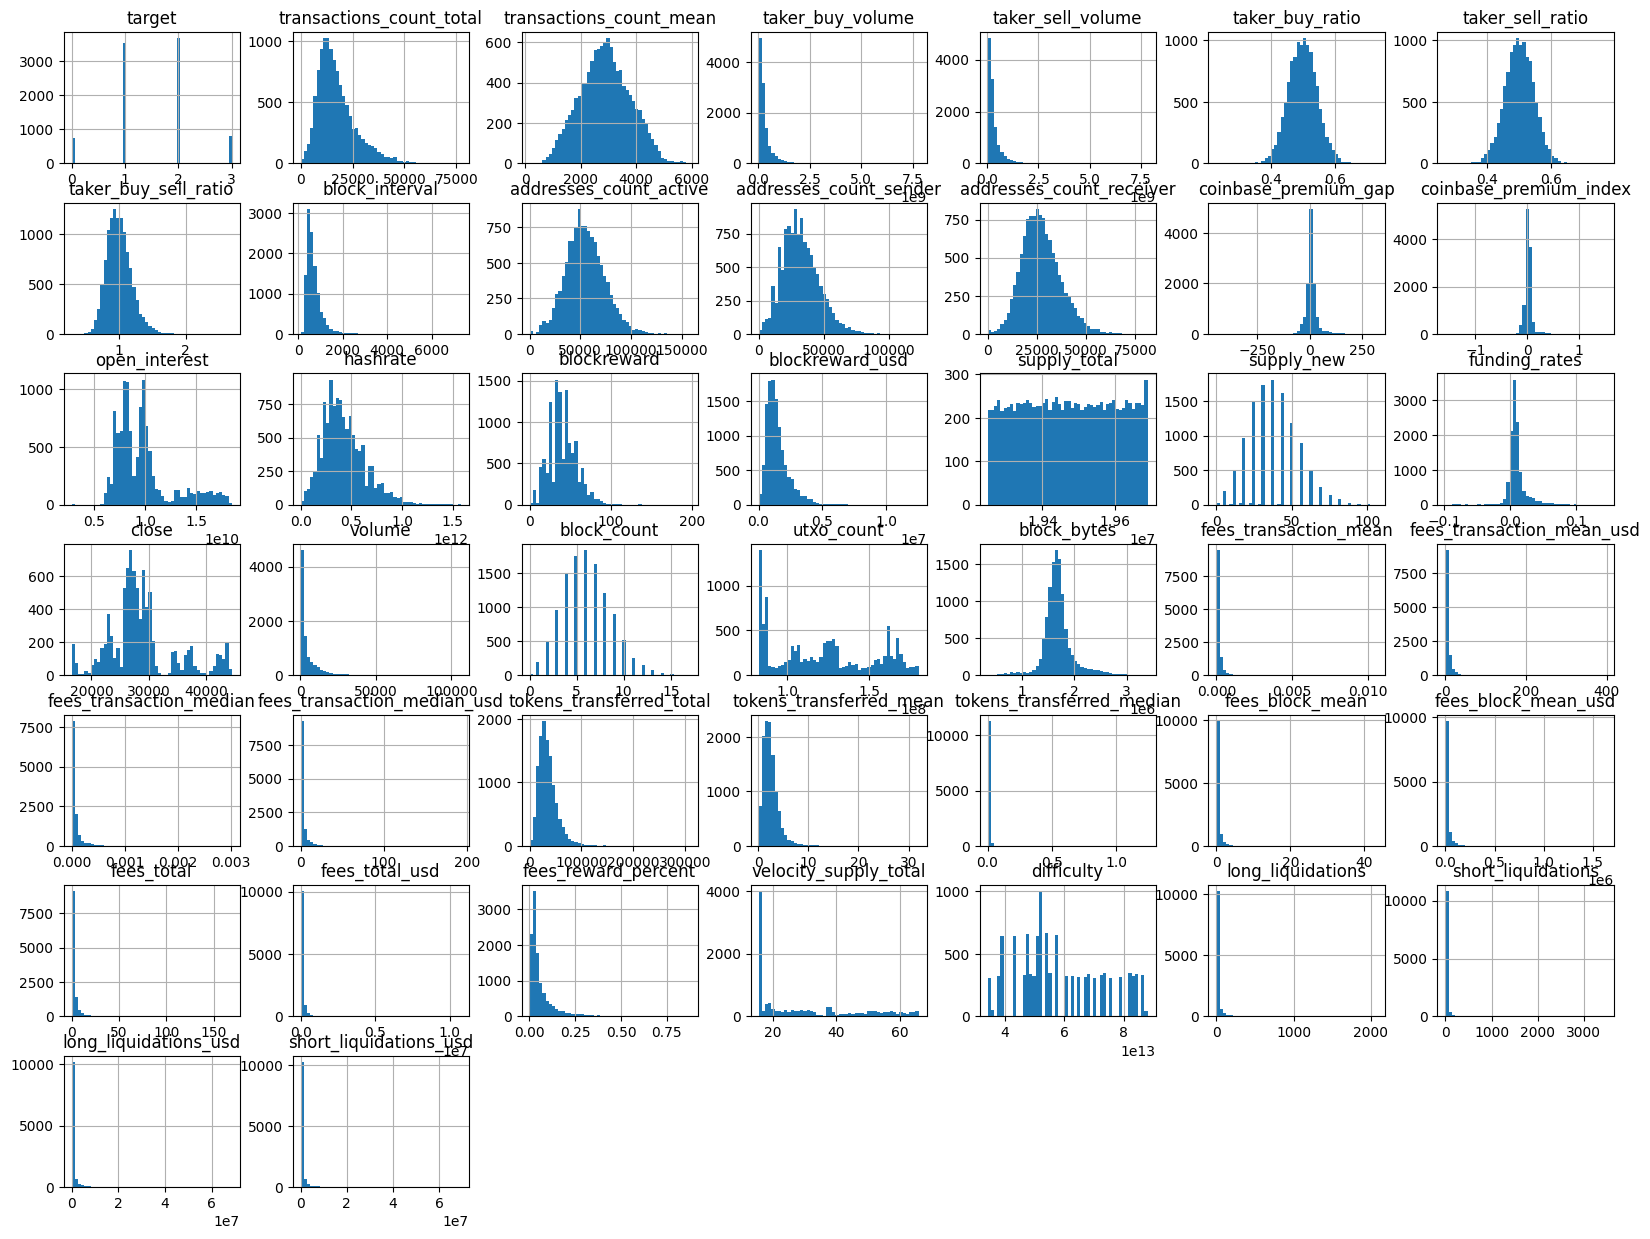

In [55]:
df.hist(bins=50, figsize=(20, 15))
plt.show()

# df.boxplot(figsize=(20, 10), rot=90)
# plt.show()

##### 상관관계 분석

In [58]:
eda_df = df.loc[df["_type"] == "train"].drop(["_type"], axis=1)

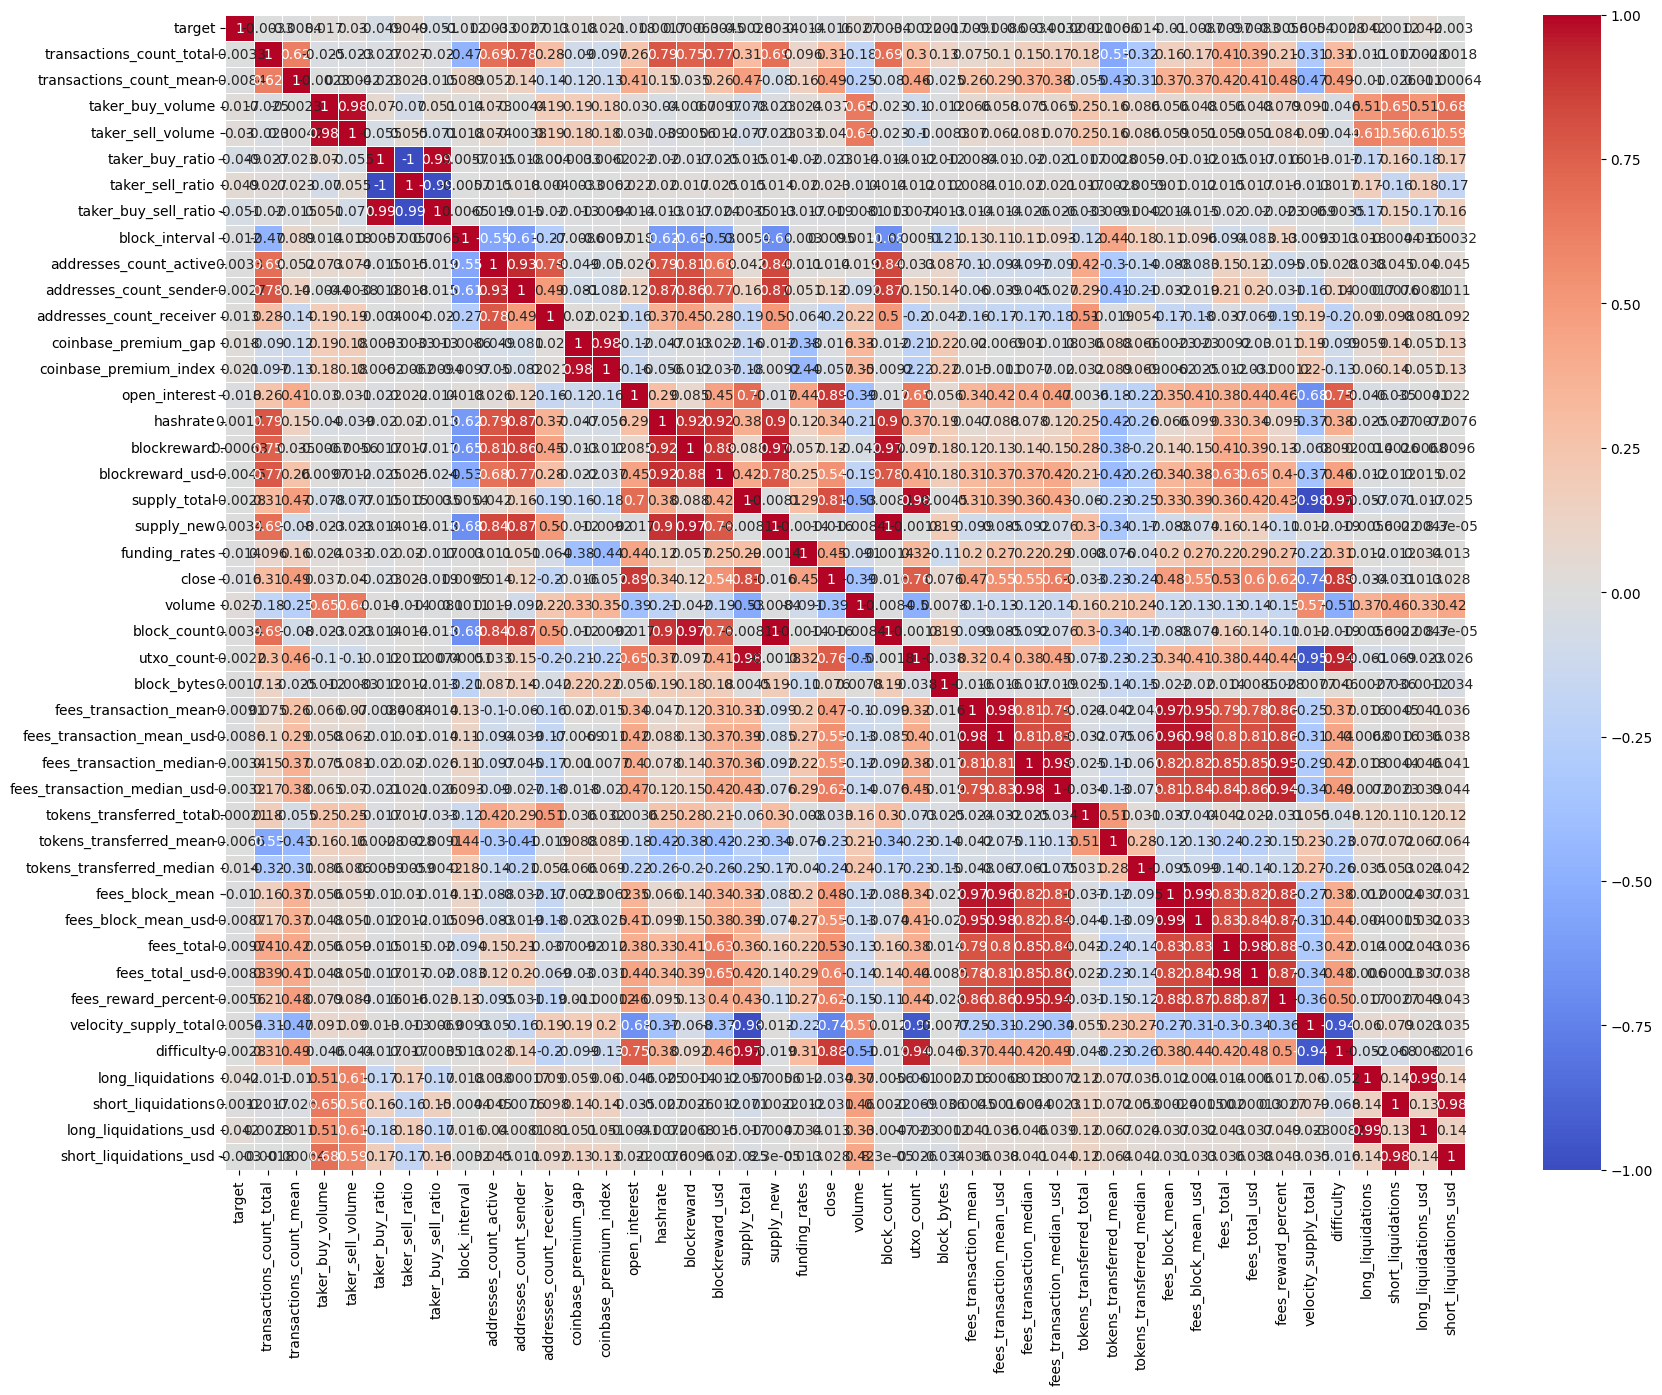

target                         1.000000
taker_sell_ratio               0.049467
long_liquidations              0.041983
long_liquidations_usd          0.041855
taker_sell_volume              0.029509
volume                         0.026774
coinbase_premium_index         0.020701
coinbase_premium_gap           0.018131
taker_buy_volume               0.016776
tokens_transferred_median      0.013730
addresses_count_receiver       0.012649
velocity_supply_total          0.005420
block_count                    0.003441
supply_new                     0.003441
addresses_count_active         0.003349
hashrate                       0.001681
block_bytes                    0.001676
short_liquidations             0.001222
blockreward                    0.000628
tokens_transferred_total       0.000206
utxo_count                    -0.002221
addresses_count_sender        -0.002719
supply_total                  -0.002774
difficulty                    -0.002822
short_liquidations_usd        -0.002957


In [60]:
# 상관관계 매트릭스 계산
corr_matrix = eda_df.drop(['ID'], axis=1).corr()

# 상관관계 히트맵
plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.show()

# 타겟과의 상관관계만 확인
target_corr = corr_matrix['target'].sort_values(ascending=False)
print(target_corr)


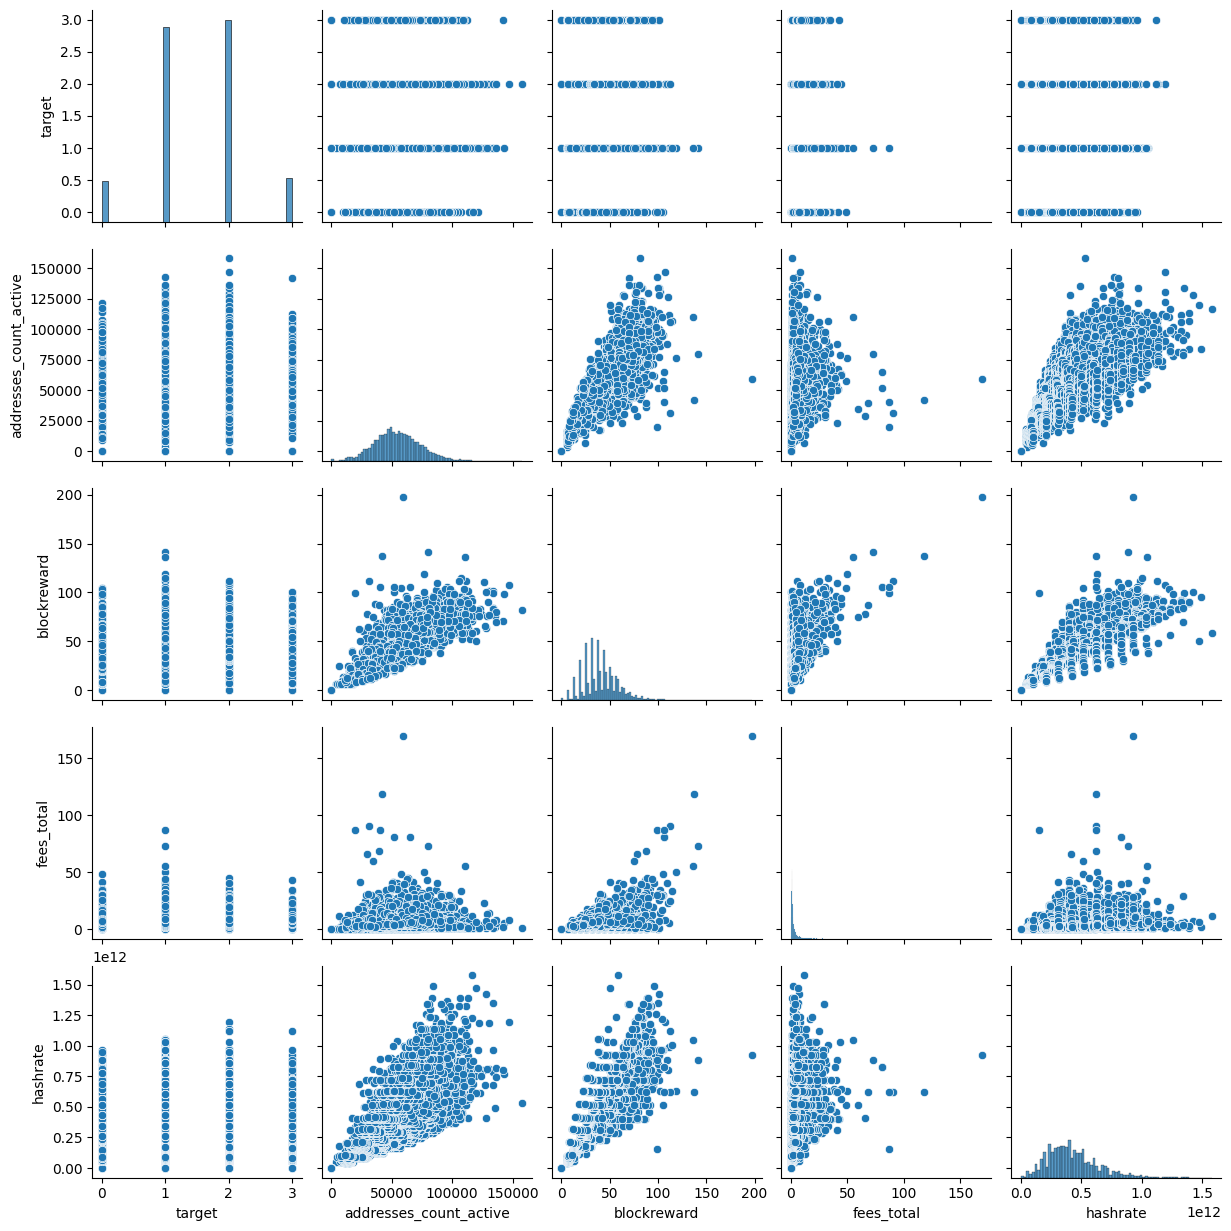

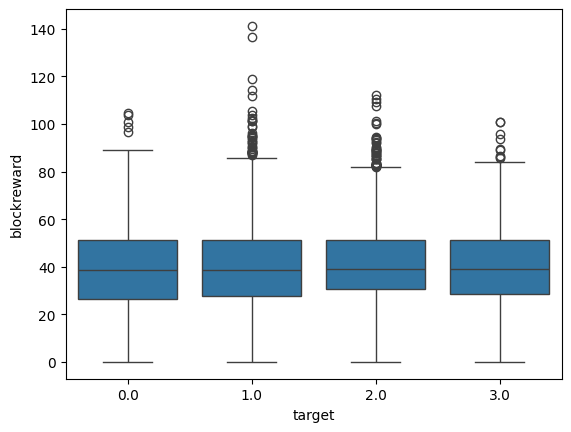

In [22]:
# seaborn의 pairplot으로 상관관계 시각화
sns.pairplot(df[['target', 'addresses_count_active', 'blockreward', 'fees_total', 'hashrate']])
plt.show()

# boxplot으로 타겟 변수와의 관계 확인
sns.boxplot(x='target', y='blockreward', data=df)
plt.show()

##### 시계열 데이터 분석

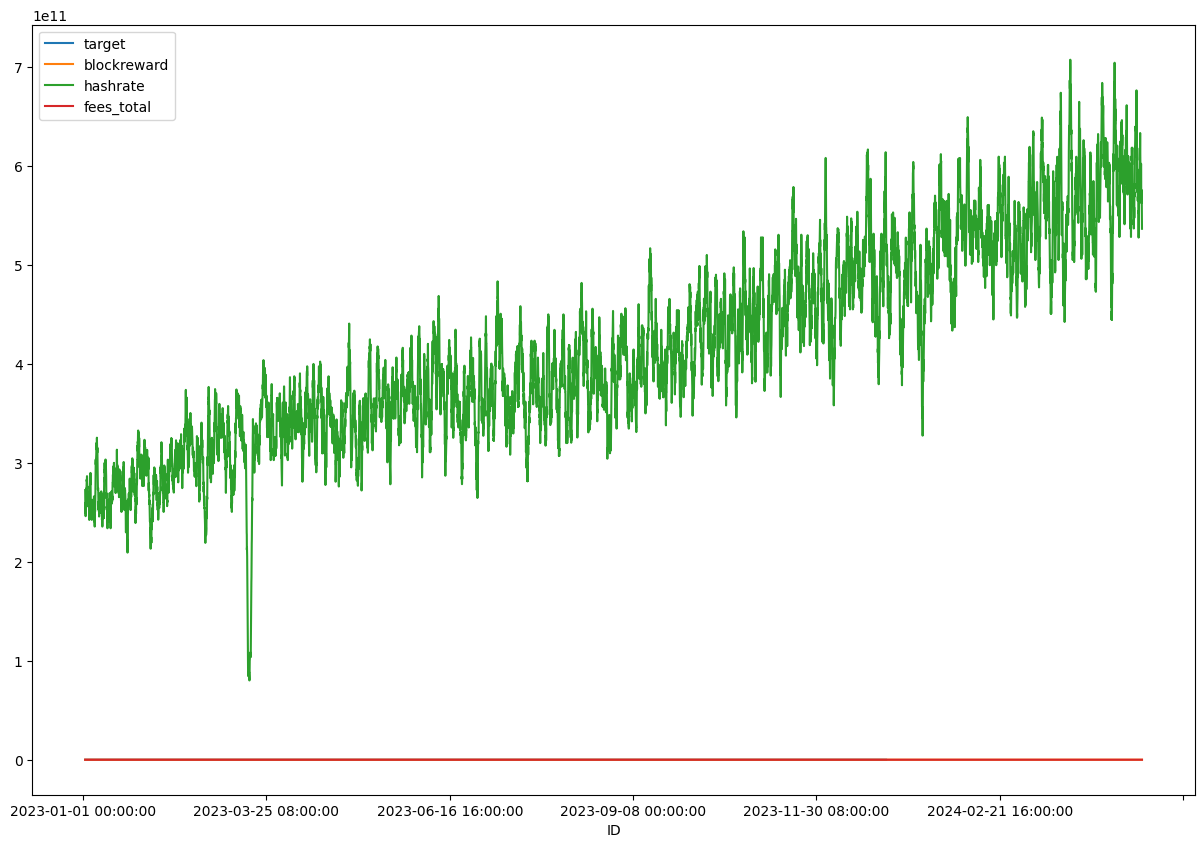

In [78]:
# 시간에 따른 주요 변수와 타겟의 트렌드 분석
df_new = df.set_index('ID')

# 타겟과 주요 변수 rolling mean 비교
df_new[['target', 'blockreward', 'hashrate', 'fees_total']].rolling(window=24).mean().plot(figsize=(15, 10))
plt.show()

##### 가격 변동에 따른 독립변수들의 변화 확인하기

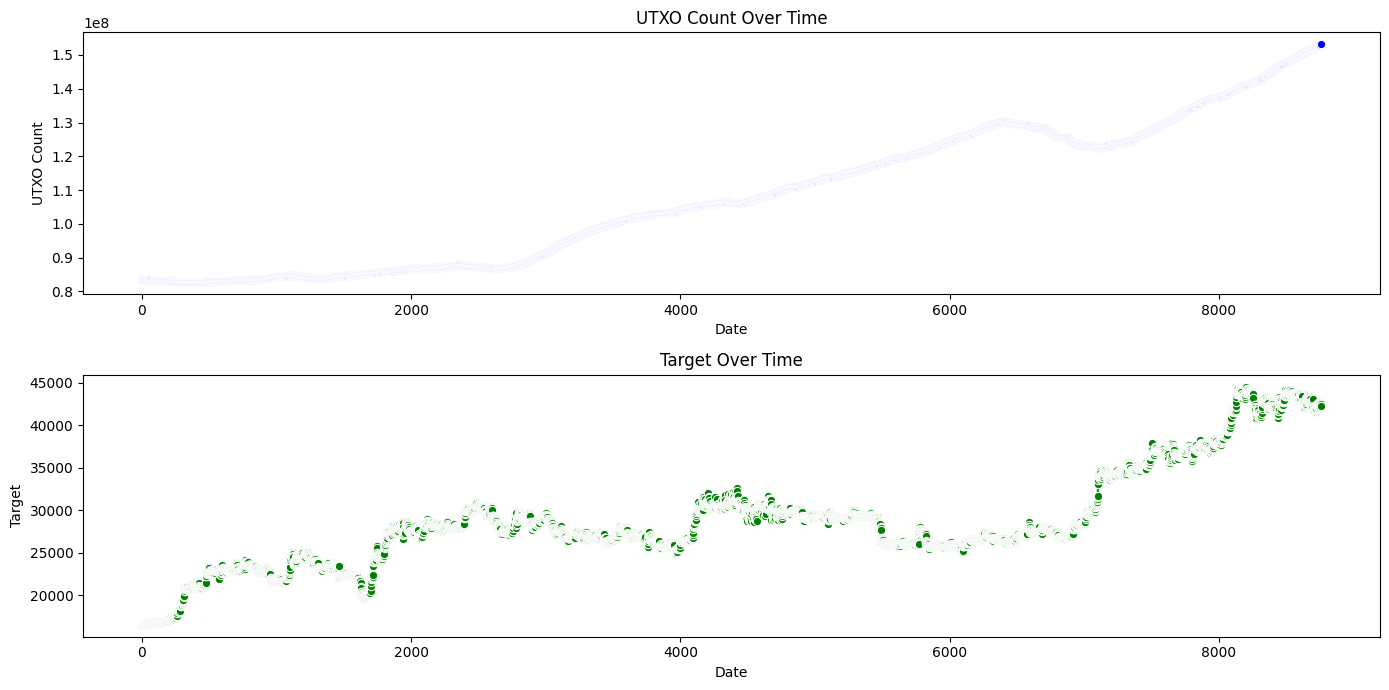

In [79]:

plt.figure(figsize=(14, 7))

# UTXO Count 시각화
plt.subplot(2, 1, 1)
sns.lineplot(data=eda_df, x=eda_df.index, y='utxo_count', marker='o', color='blue')
plt.title('UTXO Count Over Time')
plt.xlabel('Date')
plt.ylabel('UTXO Count')

# Target 시각화
plt.subplot(2, 1, 2)
sns.lineplot(data=eda_df, x=eda_df.index, y='close', marker='o', color='green')
plt.title('Target Over Time')
plt.xlabel('Date')
plt.ylabel('Target')

plt.tight_layout()
plt.show()


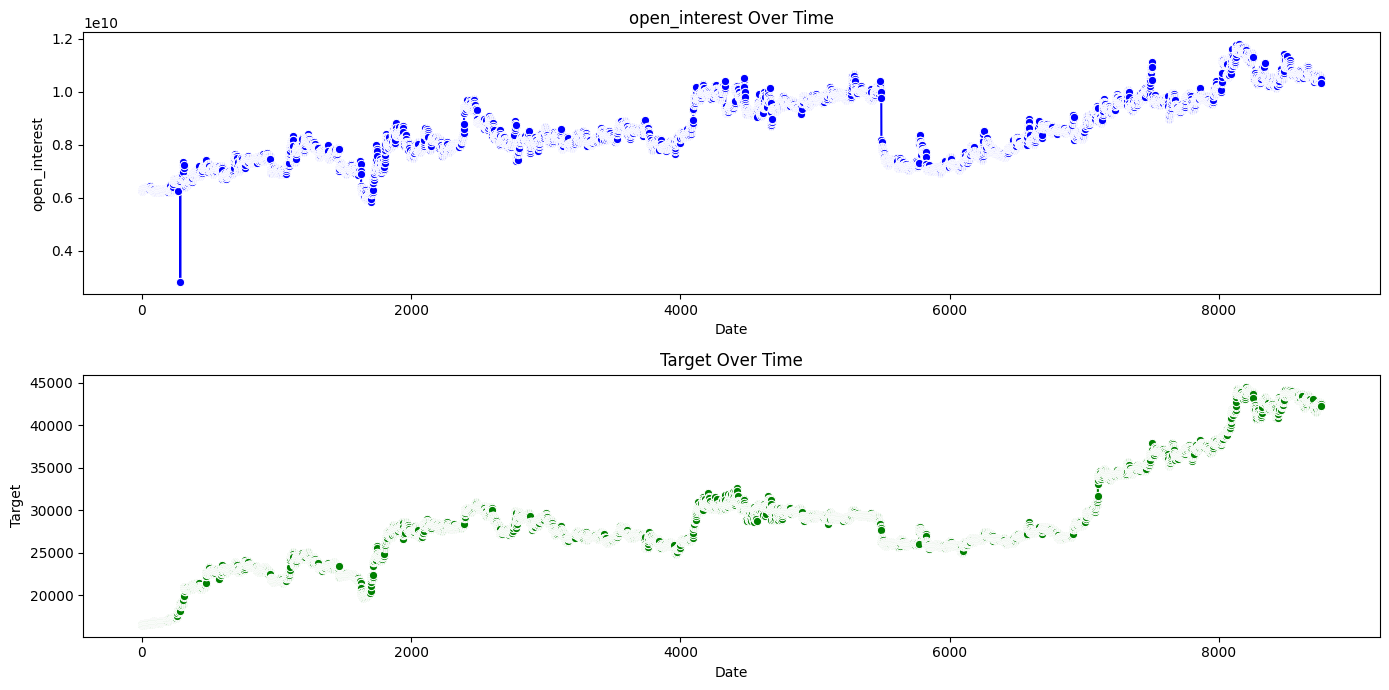

<Figure size 640x480 with 0 Axes>

In [21]:
plt.figure(figsize=(14, 7))

# UTXO Count 시각화
plt.subplot(2, 1, 1)
sns.lineplot(data=eda_df, x=eda_df.index, y='open_interest', marker='o', color='blue')
plt.title('open_interest Over Time')
plt.xlabel('Date')
plt.ylabel('open_interest')

# Target 시각화
plt.subplot(2, 1, 2)
sns.lineplot(data=eda_df, x=eda_df.index, y='close', marker='o', color='green')
plt.title('Target Over Time')
plt.xlabel('Date')
plt.ylabel('Target')

plt.tight_layout()
plt.show()

plt.tight_layout()
plt.show()

### Feature engineering

In [7]:
# 전체 독립변수에서 내가 사용할 독립변수 고르기
features = ['ID', 'target', '_type', 'funding_rates', 'open_interest',
       'taker_buy_volume', 'taker_sell_volume', 'taker_buy_ratio',
       'taker_sell_ratio', 'taker_buy_sell_ratio', 'difficulty',
       'transactions_count_total', 'transactions_count_mean', 'block_count',
       'fees_transaction_mean', 'fees_transaction_mean_usd',
       'fees_transaction_median', 'fees_transaction_median_usd',
       'fees_block_mean', 'fees_block_mean_usd', 'fees_total',
       'fees_total_usd', 'fees_reward_percent', 'hashrate', 'utxo_count',
       'tokens_transferred_total', 'tokens_transferred_mean',
       'tokens_transferred_median', 'block_interval', 'velocity_supply_total',
       'supply_total', 'supply_new', 'addresses_count_active',
       'addresses_count_sender', 'addresses_count_receiver',
       'blockreward', 'blockreward_usd', 'liquidation_diff',
       'liquidation_usd_diff', 'volume_diff', 'liquidation_diffg',
       'liquidation_usd_diffg', 'volume_diffg', 'buy_sell_volume_ratio']
fe = ['ID', 'target', '_type', 'funding_rates', 'open_interest',
      'long_liquidations', 'short_liquidations', 
       'taker_buy_volume', 'taker_sell_volume', 'taker_buy_ratio',
       'taker_sell_ratio', 'taker_buy_sell_ratio', 
       'difficulty',
       'fees_transaction_mean', 'fees_transaction_median', 
       'fees_block_mean', 'fees_total', 'fees_reward_percent', 
       'hashrate', 'utxo_count',
       'tokens_transferred_mean', 'tokens_transferred_median', 
       'supply_new', 'blockreward']

new_features = [x for x in fe if x not in features]

In [8]:
# eda 에서 파악한 차이와 차이의 음수, 양수 여부를 새로운 피쳐로 생성
df = df.assign(
    liquidation_diff=df["long_liquidations"] - df["short_liquidations"],
    liquidation_usd_diff=df["long_liquidations_usd"] - df["short_liquidations_usd"],
    volume_diff=df["taker_buy_volume"] - df["taker_sell_volume"],
    liquidation_diffg=np.sign(df["long_liquidations"] - df["short_liquidations"]),
    liquidation_usd_diffg=np.sign(df["long_liquidations_usd"] - df["short_liquidations_usd"]),
    volume_diffg=np.sign(df["taker_buy_volume"] - df["taker_sell_volume"]),
    buy_sell_volume_ratio=df["taker_buy_volume"] / (df["taker_sell_volume"] + 1),
)
# category, continuous 열을 따로 할당해둠
category_cols = ["liquidation_diffg", "liquidation_usd_diffg", "volume_diffg"]
conti_cols = [_ for _ in (df.columns)[3:] if _ not in ["ID", "target", "_type"]] + [
    "buy_sell_volume_ratio",
    "liquidation_diff",
    "liquidation_usd_diff",
    "volume_diff",
]

In [9]:
def shift_feature(
    df: pd.DataFrame,
    conti_cols: List[str],
    intervals: List[int],
) -> List[pd.Series]:
    """
    연속형 변수의 shift feature 생성
    Args:
        df (pd.DataFrame)
        conti_cols (List[str]): continuous colnames
        intervals (List[int]): shifted intervals
    Return:
        List[pd.Series]
    """
    df_shift_dict = [
        df[conti_col].shift(interval).rename(f"{conti_col}_{interval}")
        for conti_col in conti_cols
        for interval in intervals
    ]
    return df_shift_dict

# 최대 24시간의 shift 피쳐를 계산
shift_list = shift_feature(
    df=df, conti_cols=conti_cols, intervals=[_ for _ in range(1, 24)]
)

In [10]:
# concat 하여 df 에 할당
df = pd.concat([df, pd.concat(shift_list, axis=1)], axis=1)

# 타겟 변수를 제외한 변수를 forwardfill, -999로 결측치 대체
_target = df["target"]
df = df.ffill().fillna(-999).assign(target = _target)
df = df.loc[:, ~df.columns.duplicated()]
df = df.drop(columns=new_features)

# _type에 따라 train, test 분리
train_df = df.loc[df["_type"]=="train"].drop(columns=["_type"])
test_df = df.loc[df["_type"]=="test"].drop(columns=["_type"])

### Model Training

In [25]:
# train_test_split 으로 valid set, train set 분리
x_train, x_valid, y_train, y_valid = train_test_split(
    train_df.drop(["target", "ID"], axis = 1),
    train_df["target"].astype(int),
    test_size=0.2,
    random_state=42,
)

# train_df_new = train_df.set_index('ID')
# x_train = train_df_new.drop(["target"], axis = 1)[:1753]
# x_valid = train_df_new.drop(["target"], axis = 1)[1752:]
# y_train = train_df_new["target"].astype(int)[:1753]
# y_valid = train_df_new["target"].astype(int)[1752:]

# lgb dataset
train_data = lgb.Dataset(x_train, label=y_train)
valid_data = lgb.Dataset(x_valid, label=y_valid, reference=train_data)

# lgb params
params = {
    "boosting_type": "gbdt",
    "objective": "multiclass",
    "metric": "multi_logloss",
    "num_class": 4,
    "num_leaves": 20,
    "learning_rate": 0.0422082054163454,
    "n_estimators": 45,
    "random_state": 42,
    "verbose": 0,
}

# lgb train
lgb_model = lgb.train(
    params=params,
    train_set=train_data,
    valid_sets=valid_data,
    num_boost_round=100
)

# lgb predict
y_valid_pred = lgb_model.predict(x_valid)
y_valid_pred_class = np.argmax(y_valid_pred, axis = 1)

# score check
accuracy = accuracy_score(y_valid, y_valid_pred_class)
auroc = roc_auc_score(y_valid, y_valid_pred, multi_class="ovr")

print(f"acc: {accuracy}, auroc: {auroc}")

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


acc: 0.4372146118721461, auroc: 0.6425681058058073


In [14]:
# performance 체크후 전체 학습 데이터로 다시 재학습
x_train = train_df.drop(["target", "ID"], axis = 1)
y_train = train_df["target"].astype(int)
train_data = lgb.Dataset(x_train, label=y_train)
lgb_model = lgb.train(
    params=params,
    train_set=train_data,
)

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


##### 옵튜나

In [23]:
import optuna
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

def objective(trial):
    # 최적화할 하이퍼파라미터 정의
    params = {
        "boosting_type": "gbdt",
        "objective": "multiclass",
        "metric": "multi_logloss",
        "num_class": 4,
        # parameter space 생성(참고 : https://optuna.readthedocs.io/en/stable/reference/generated/optuna.trial.Trial.html)
        "num_leaves": trial.suggest_int("num_leaves", 20, 100),
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 1e-1),
        "n_estimators": trial.suggest_int("n_estimators", 10, 100),
        "random_state": 42,
        "verbose": -1,
    }

    x_train, x_valid, y_train, y_valid = train_test_split(
        train_df.drop(["target", "ID"], axis=1),
        train_df["target"].astype(int),
        test_size=0.2,
        random_state=42,
    )

    train_data = lgb.Dataset(x_train, label=y_train)
    valid_data = lgb.Dataset(x_valid, label=y_valid, reference=train_data)

    model = lgb.train(
        params=params,
        train_set=train_data,
        valid_sets=[valid_data],
        num_boost_round=100,
    )
    
    # valid에 대한 predict & loss calc
    preds = model.predict(x_valid)
    loss = log_loss(y_valid, preds)
    
    return loss

# Optuna Study 생성
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

print("Best parameters:", study.best_params)
print("Best score:", study.best_value)

# best_params로 최종 모델 train
best_params = study.best_params
best_params.update({
    "boosting_type": "gbdt",
    "objective": "multiclass",
    "metric": "multi_logloss",
    "num_class": 4,
    "random_state": 42,
    "verbose": 0,
})

final_model = lgb.train(
    params=best_params,
    train_set=lgb.Dataset(train_df.drop(["target", "ID"], axis=1), label=train_df["target"].astype(int)),
    num_boost_round=100,
)

[I 2024-09-13 07:56:00,077] A new study created in memory with name: no-name-6d4bed31-7816-4818-a878-c565d4fe7bed
/tmp/ipykernel_89492/1821720801.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 1e-1),
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2024-09-13 07:56:23,020] Trial 0 finished with value: 1.1516989847775694 and parameters: {'num_leaves': 45, 'learning_rate': 0.004207274036080053, 'n_estimators': 92}. Best is trial 0 with value: 1.1516989847775694.
/tmp/ipykernel_89492/1821720801.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be remov

Best parameters: {'num_leaves': 20, 'learning_rate': 0.0422082054163454, 'n_estimators': 45}
Best score: 1.1242632061473843


In [24]:
# lgb predict
y_valid_pred = final_model.predict(x_valid)
y_valid_pred_class = np.argmax(y_valid_pred, axis = 1)

# score check
accuracy = accuracy_score(y_valid, y_valid_pred_class)
auroc = roc_auc_score(y_valid, y_valid_pred, multi_class="ovr")

print(f"acc: {accuracy}, auroc: {auroc}")

acc: 0.7054794520547946, auroc: 0.9078913668342381


### Inference

In [15]:
y_test_pred = lgb_model.predict(test_df.drop(["target", "ID"], axis = 1))
y_test_pred_class = np.argmax(y_test_pred, axis = 1)

### Output File Save

In [16]:
submission = submission.assign(target = y_test_pred_class)
submission.to_csv("output.csv", index=False)